In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam.elements import optic
from beam import interactions
from ionization import ionization
from ionization import adk
from lens import profile
from lens import bessel
from lens import ray
import matplotlib.pyplot as plt
from ionization import adk
from scipy.interpolate import interp1d
from scipy.optimize import newton

path = '/media/robert/Data_Storage/Data/Filamentation/Spherical_Lens/'
lam = 0.8
tau = 35.

In [2]:
# The goal is to create a 100um diameter, 5mm long plasma in as a high a density as possible
# The maximum density possible is the critical density for the laser at 3.49e21
# If the laser is frequency doubled then the critical density is 1.40e22
# The field from a Gaussian laser beam is given by
r = np.linspace(-400, 400, 1000)
z = np.linspace(-10e4, 10e4, 1000)
ext = [-100, 100, -400, 400]
def get_field(r, z, energy, w0):
    E0 = 2*np.sqrt(377*energy/np.pi/tau*1e15)/w0*1e6/1e9
    k = 2*np.pi/lam
    zR = np.pi*w0**2/lam
    wz = w0*np.sqrt(1+(z[:, None]/zR)**2)
    E = E0*w0/wz*np.exp(-r[None, :]**2/wz**2)
    return E
def plot_laser_plasma(I, ne, ext):
    plt.figure(figsize=(16, 4))
    plt.subplot(121)
    plt.imshow(np.flipud(np.transpose(I)), aspect='auto', extent=ext, cmap='viridis')
    cb = plt.colorbar()
    cb.set_label(r'Laser Intensity ($10^{14} W/cm^2$)')
    plt.xlabel('z (mm)')
    plt.ylabel(r'x ($\mathrm{\mu m}$)')
    plt.ylim(-200, 200)

    plt.subplot(122)
    plt.imshow(np.flipud(np.transpose(ne)), aspect='auto', extent=ext, cmap='plasma')
    cb = plt.colorbar()
    cb.set_label(r'$n_e$ ($\mathrm{cm^-3}$)')
    plt.xlabel('$z$ (mm)')
    plt.ylabel(r'$x$ ($\mathrm{\mu m}$)')
    plt.ylim(-200, 200)
    plt.tight_layout()
    plt.show()

In [3]:
# Extract length and average plasma width using full width half max
def fwhm(x, y):
    Y_half = np.amax(y)/2
    d = np.sign(Y_half - y[0:-1]) - np.sign(Y_half - y[1:])
    left_idx = np.where(d > 0)[0]
    right_idx = np.where(d < 0)[-1]
    return (x[right_idx] - x[left_idx])[0]

def size(z, r, ne, thresh):
    # FWHM along the length of the plasma and average FWHM for all slices above threshold
    Nz = len(z)
    Nr = len(r)
    l = 0.0
    if np.amax(ne[:, int(Nr/2)]) > thresh:
        l = fwhm(z, ne[:, int(Nr/2)])
    r_tot = 0
    n = 0
    for i in range(Nz):
        if np.amax(ne[i, :]) > thresh:
            r_tot += fwhm(r, ne[i, :])
            n += 1
    if n==0:
        w = 0
    else:
        w = r_tot/n
    return l, w

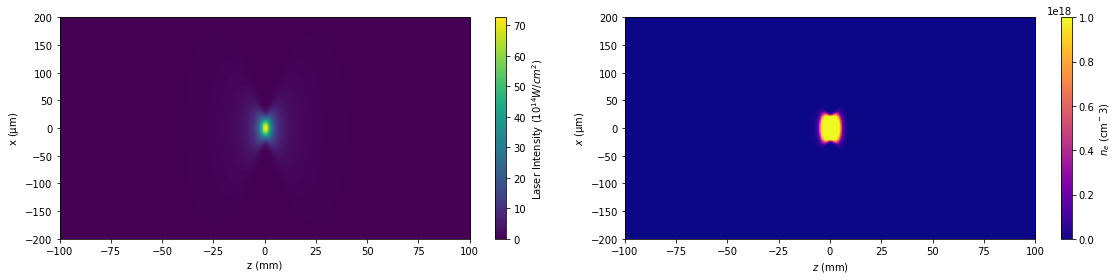

(10810.810810810814, 49.039515706182364)

In [4]:
energy = 2.5e-3 #J
w0 = 25 #um
ne0 = 1e18 #cm^-3
E = get_field(r, z, energy, w0)
I = ionization.intensity_from_field(E)
atom = ionization.He
ne = ne0*adk.gaussian_frac(atom['EI'], abs(E), tau, atom['Z'], atom['l'], atom['m'])
plot_laser_plasma(I, ne, ext)
size(z, r, ne, 0.95*1e18)

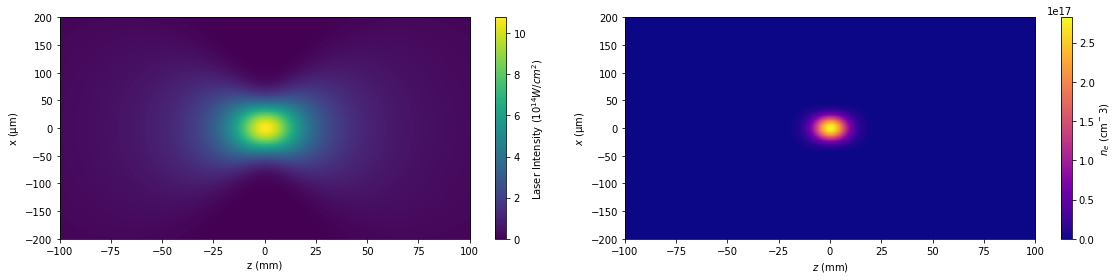

(0.0, 0)

In [5]:
energy = 2.5e-3 #J
w0 = 65 #um
ne0 = 1e18 #cm^-3
E = get_field(r, z, energy, w0)
I = ionization.intensity_from_field(E)
atom = ionization.He
ne = ne0*adk.gaussian_frac(atom['EI'], abs(E), tau, atom['Z'], atom['l'], atom['m'])
plot_laser_plasma(I, ne, ext)
size(z, r, ne, 0.95*1e18)

In [6]:
Ne = 40
Nw = 40
E_min = 1e-3
E_max = 20e-3
w0_min = 5
w0_max = 35
energy = np.linspace(E_min, E_max, Ne)
w0 = np.linspace(w0_min, w0_max, Nw)
length = np.zeros((Ne, Nw))
width = np.zeros((Ne, Nw))
for i in range(Ne):
    for j in range(Nw):
        E = get_field(r, z, energy[i], w0[j])
        I = ionization.intensity_from_field(E)
        atom = ionization.He
        ne = adk.gaussian_frac(atom['EI'], abs(E), tau, atom['Z'], atom['l'], atom['m'])
        length[i, j], width[i, j] = size(z, r, ne, 0.95)

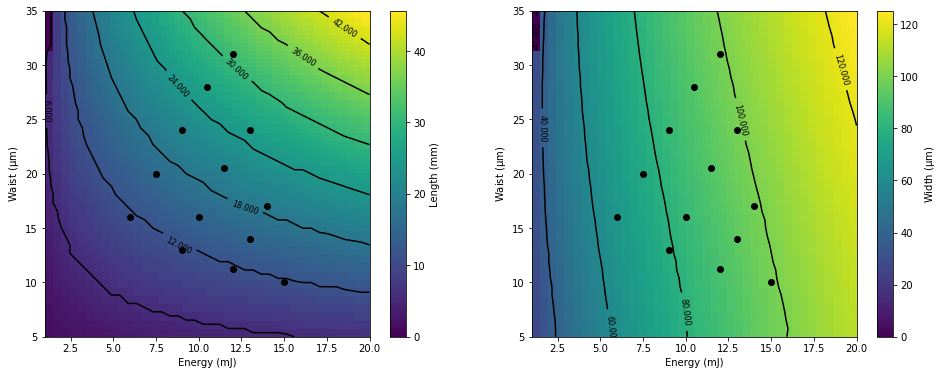

In [7]:
x = [15, 14, 13, 12,   12,  9,  6, 13, 10, 11.5, 7.5,  9, 10.5]
y = [10, 17, 24, 31, 11.2, 13, 16, 14, 16, 20.5,  20, 24, 28]
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.imshow(np.flipud(np.transpose(length/1e3)), aspect='auto', cmap='viridis', 
           extent=[E_min*1e3, E_max*1e3, w0_min, w0_max])
cb = plt.colorbar()
cb.set_label(r'Length (mm)')
contours = plt.contour(energy*1e3, w0, np.transpose(length/1e3), colors='black');
plt.plot(x, y, 'k.', markersize=12)
plt.clabel(contours, inline=True, fontsize=8)
plt.xlabel('Energy (mJ)')
plt.ylabel('Waist ($\mathrm{\mu m}$)')
plt.subplot(122)
plt.imshow(np.flipud(np.transpose(width)), aspect='auto', cmap='viridis',
           extent=[E_min*1e3, E_max*1e3, w0_min, w0_max])
cb = plt.colorbar()
cb.set_label(r'Width ($\mathrm{\mu m}$)')
contours = plt.contour(energy*1e3, w0, np.transpose(width), colors='black');
plt.plot(x, y, 'k.', markersize=12)
plt.clabel(contours, inline=True, fontsize=8)
plt.xlabel('Energy (mJ)')
plt.ylabel('Waist ($\mathrm{\mu m}$)')
plt.show()

In [32]:
pulseNx = 2**11
pulseNy = 2**11
pulseX = 4e3
pulseY = 4e3
N = 500
Z = 8e4
z = np.linspace(0, Z, N)
pulseParams = {
    'Nt' : 2**6,
    'Nx' : pulseNx,
    'Ny' : pulseNy,
    'X' : pulseX,
    'Y' : pulseY,
    'T' : 3*tau,
    'lam' : lam,
    'path' : path,
    'load' : False,
    'threads' : 4,
    'cyl' : True,
    'tau' : tau,
    'z0' : -5e4
}
plasmaParams = {
    'Nx' : pulseNx,
    'Ny' : pulseNy,
    'Nz' : N,
    'X' : pulseX,
    'Y' : pulseY,
    'Z' : Z,
    'atom' : ionization.He,
    'path' : path,
    'load' : False,
    'cyl' : True
}

ext = [-50, 30, -pulseX/2, pulseX/2]   
def intensity_field(energy, w0, ne0):
    pulseParams['name'] = 'w0=%0.0fum_energy=%0.1fmJ' % (w0, energy*1e3)
    pulseParams['E0'] = 2*np.sqrt(377*energy/np.pi/tau*1e15)/w0*1e6/1e9
    pulseParams['waist'] = w0
    beam = laserbeam.GaussianLaser(pulseParams)
    beam.propagate(z, 1.0)
    e = np.zeros((N, pulseNx), dtype='complex128')
    for i in range(N):
        e[i, :] = beam.load_field(i+1)[0]

    ne = ne0*adk.gaussian_frac(ionization.He['EI'], abs(e), tau, ionization.He['Z'], ionization.He['l'])
    I = beam.intensity_from_field(e)
    return I, ne

def refraction_field(energy, w0, ne0):
    pulseParams['name'] = 'w0=%0.0fum_energy=%0.1fmJ_pulse' % (w0, energy*1e3)
    pulseParams['E0'] = 2*np.sqrt(377*energy/np.pi/tau*1e15)/w0*1e6/1e9
    pulseParams['waist'] = w0
    pulse = laserpulse.GaussianPulse(pulseParams)
    plasmaParams['name'] = 'w0=%0.0fum_energy=%0.1fmJ_plasma' % (w0, energy*1e3)
    plasmaParams['n0'] = ne0/1e17
    helium = plasma.UniformPlasma(plasmaParams)
    interactions.pulse_plasma(pulse, helium)
    e = np.zeros((N, pulseNx), dtype='complex128')
    ne = np.zeros((N, pulseNx))
    for i in range(0, N-1):
        ne[i, :] = helium.load_plasma_density(i)[0]
    for i in range(N):
        e[i, :] = pulse.load_field(i)[0][int(pulseParams['Nt']/2), :]
    I = ionization.intensity_from_field(e)
    ne = ne*1e17
    return I, ne

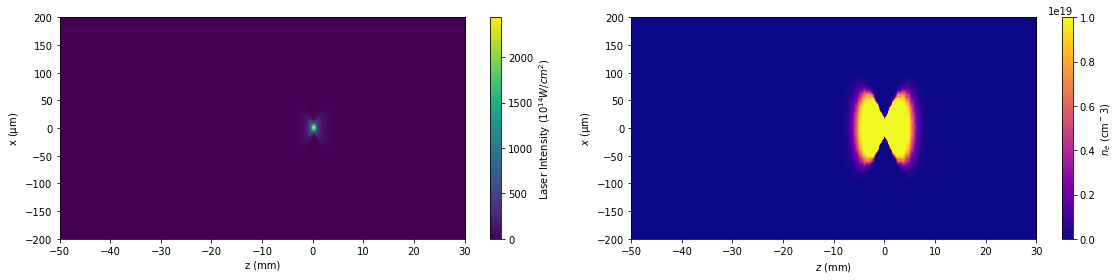

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/robert/anaconda3/envs/CU-PWFA/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-33-fb3a401cfb03>", line 4, in <module>
    I, ne = refraction_field(x[i]*1e-3, y[i], 1e19)
  File "<ipython-input-32-e05e2898c2b2>", line 59, in refraction_field
    interactions.pulse_plasma(pulse, helium)
  File "../../python/beam/interactions.py", line 31, in pulse_plasma
    plasma.load_num_den, plasma.load_plasma_den)
  File "beam/calc/plasma.pyx", line 81, in beam.calc.plasma.plasma_refraction
  File "beam/calc/laser.pyx", line 124, in beam.calc.laser.fourier_step
  File "beam/calc/laser.pyx", line 159, in beam.calc.laser.fourier_step
  File "pyfftw/pyfftw.pyx", line 1438, in pyfftw.pyfftw.FFTW.__call__
  File "/home/robert/anaconda3/envs/CU-PWFA/lib/python3.6/site-packages/numpy/core/numeric.py", line 541, in asanyarray
    @set_module('nump

KeyboardInterrupt: 

In [33]:
for i in range(len(x)):
    I, ne = intensity_field(x[i]*1e-3, y[i], 1e19)
    plot_laser_plasma(I, ne, ext)
    I, ne = refraction_field(x[i]*1e-3, y[i], 1e19)
    plot_laser_plasma(I, ne, ext)